<a href="https://colab.research.google.com/github/kavyajeetbora/nlp_doc/blob/master/notebooks/01_simple_local_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the environment

Takes about 3 mins to setup

In [1]:
# Perform Google Colab installs (if running in Google Colab)
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+ (for efficient sdpa implementation)
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm # for progress bars
    !pip install sentence-transformers # for embedding models
    !pip install accelerate # for quantization model loading
    !pip install bitsandbytes # for quantizing models (less storage space)
    !pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference

[INFO] Running in Google Colab, installing requirements.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 M

## Download the PDF

Based on which we will build our QA application

In [2]:
# The URL of the PDF you want to download
!wget "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf" -O "Human Nutrition.pdf"

--2024-04-12 11:52:50--  https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf
Resolving pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)... 128.171.43.156
Connecting to pressbooks.oer.hawaii.edu (pressbooks.oer.hawaii.edu)|128.171.43.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26891229 (26M) [application/pdf]
Saving to: ‘Human Nutrition.pdf’

Human Nutrition.pdf 100%[===================>]  25.64M  19.8MB/s    in 1.3s    

2024-04-12 11:52:51 (19.8 MB/s) - ‘Human Nutrition.pdf’ saved [26891229/26891229]



## Read the content of the PDF

We will use PyMuPDF

In [3]:
import fitz
from tqdm.notebook import tqdm
import random

In [4]:
## Some text formatting function before extracting the text

def text_formatter(text:str)->str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text


## Here we can define more text preprocessing functions

About token

Tokens can be thought of as pieces of words. Before the API processes the request, the input is broken down into tokens. These tokens are not cut up exactly where the words start or end - tokens can include trailing spaces and even sub-words

Use this [tokenizer tool](https://platform.openai.com/tokenizer) to try it out

In [5]:
pdf = fitz.open('Human Nutrition.pdf')

def open_and_read_pdf(pdf_path:str) -> list[dict]:
    doc = fitz.open(pdf_path)

    pages_and_text = []

    for page_number, page in tqdm(enumerate(doc)):
        raw_text = page.get_text()
        cleaned_text = text_formatter(text=raw_text)
        pages_and_text.append(
            {
                "page_number": page_number - 41,
                "page_char_count": len(cleaned_text),
                "page_word_count": len(cleaned_text.split(" ")),
                "page_sentence_count": len(cleaned_text.split(". ")),
                "page_token_count": len(cleaned_text)/ 4, ## One token is ~ 4
                "text": cleaned_text
            }
        )

    return pages_and_text


In [6]:
pages_and_text = open_and_read_pdf("Human Nutrition.pdf")

0it [00:00, ?it/s]

In [7]:
random.sample(pages_and_text,k=3)

[{'page_number': 158,
  'page_char_count': 1625,
  'page_word_count': 286,
  'page_sentence_count': 11,
  'page_token_count': 406.25,
  'text': 'reactions as it can store a large amount of heat, is electrically  neutral, and has a pH of 7.0, meaning it is not acidic or basic.  Additionally, water is involved in many enzymatic reactions as an  agent to break bonds or, by its removal from a molecule, to form  bonds.  Water As a Lubricant/Shock Absorber  Many may view the slimy products of a sneeze as gross, but  sneezing is essential for removing irritants and could not take place  without water. Mucus, which is not only essential to discharge nasal  irritants, is also required for breathing, transportation of nutrients  along the gastrointestinal tract, and elimination of waste materials  through the rectum. Mucus is composed of more than 90 percent  water and a front-line defense against injury and foreign invaders.  It protects tissues from irritants, entraps pathogens, and contains  

## Data analysis of the text

In [8]:
import pandas as pd

df = pd.DataFrame(pages_and_text)
df.sample(3)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,text
198,157,1775,314,15,443.75,Water is the foundation of all life—the surfac...
250,209,1186,213,8,296.50,Water Concerns UNIVERSITY OF HAWAI‘I AT MĀNOA...
360,319,1118,195,8,279.50,Digestion and Absorption of Lipids UNIVERSIT...


In [9]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15
std,348.86,560.44,95.75,6.19,140.11
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.75,134.00,4.00,190.69
50%,562.50,1232.50,215.00,10.00,308.12
75%,864.25,1605.25,271.25,14.00,401.31
max,1166.00,2308.00,429.00,32.00,577.00


<Axes: xlabel='page_token_count', ylabel='Count'>

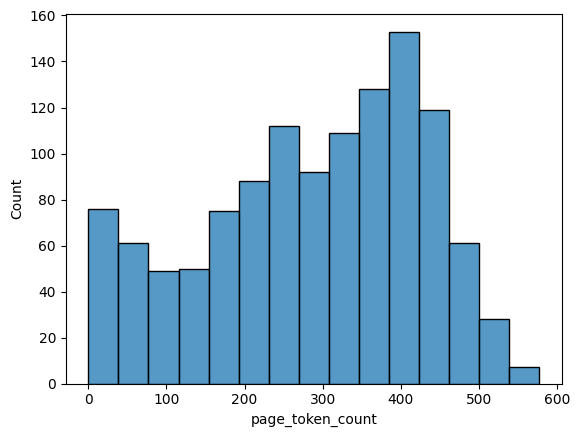

In [10]:
import seaborn as sns

sns.histplot(x='page_token_count', data=df)

Why would we care about token count ?

token count is important to think about:
1. Embedding and LLM models donot deal with infinite tokens


For example the embedding model called [all-mp-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) takes 384 tokens as input. So if we put a input with more than this then the model will cut down the text and information would be lost

As fpr LLMs, they can't accept unlimited tokens

All-mp-base-v2 is not the best embedding model out there but it is small in size so it is easy to get started. Here you can explore the leaderboard to check out the best embedding model: [MTEB Leaderboard on hugging face](https://huggingface.co/spaces/mteb/leaderboard)

## Further text processing (splitting pages into sentences)

For Splitting text into sentences we can use:
1. Manually spitting on ". "
2. Or more robust way is to use spaCy or nltk

We will use spacy [sentencizer](https://spacy.io/api/sentencizer)

In [11]:
from spacy.lang.en import English

nlp = English()

## Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

## Create document instance as an example
doc = nlp("This is a sentence. This is another sentence. And this is the last sentence")
assert len(list(doc.sents)) == 3

## Print out the sentences
list(doc.sents)

[This is a sentence., This is another sentence., And this is the last sentence]

In [12]:
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)

    item['sentences'] = list(map(str, item['sentences']))

    item['page_sentence_count_spacy'] = len(item['sentences'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_text, k=1)

[{'page_number': 214,
  'page_char_count': 1512,
  'page_word_count': 239,
  'page_sentence_count': 13,
  'page_token_count': 378.0,
  'text': 'Source: Image credit Robert Tauxe.  Drinking Water Week. Centers for Disease Control and Prevention.  http:/ /www.cdc.gov/features/drinkingwater/graph.html. Updated  May 17, 2012. Aceessed September 22, 2017.  Chlorine reaction with inadequately filtered water can result in  the formation of potentially harmful substances. Some of these  chlorinated compounds, when present at extremely high levels,  have been shown to cause cancer in studies conducted in rodents.  In addition to many other contaminants, the EPA has set maximum  contaminant levels (legal threshold limits) for these chlorinated  compounds in water, in order to guard against disease risk. The  oversight of public water systems in this country is not perfect  and water-borne illnesses are significantly underreported; however,  there are far fewer cases of water-borne illnesses than

In [14]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.59,198.89,9.97,287.15,10.32
std,348.86,560.44,95.75,6.19,140.11,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,134.00,4.00,190.69,5.00
50%,562.50,1232.50,215.00,10.00,308.12,10.00
75%,864.25,1605.25,271.25,14.00,401.31,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


## Chunking our sentences together


The concept of splitting the larger pieces of text into smaller ones is referred to as text splitting or chunking

There is no 100% correct way of doing this. Still on research. For demonstration we will keep it simple, we will split the text into group of 10 sentences.

There are frameworks like LangChain which can help with splitting the text into chunks: [Text-Splitters in LangChain](https://python.langchain.com/docs/modules/data_connection/document_transformers/)


1. Model compatibility: You may want to split a long document into smaller chunks that can fit into your **model's context window**

Say we have a sentence like this and we tokenize it:

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/0*fS-xiimLEZDBO6JX.png' height=200/>

This long sentence results in 68 tokens. But may be there will be sentence that will be longer than this and results in tokens more than the model token limit


Also we don't want to use more tokens that may result in higher price and computation:

GPT 4 Token limits and corresponding price:

<img src='https://www.slideteam.net/media/catalog/product/cache/1280x720/c/h/chat_gpt_4_api_pricing_details_how_to_use_openai_api_in_business_chatgpt_ss_slide01.jpg' height=200/>





In [15]:
chunk_size=10

## Create a function to split the list of texts recursively into chunk size
## E.g = [20] -> [10,10] or [25] -> [10,10,5]

def split_list(input_list: list, slice_size:int) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

## Test
test_list = list(range(25))
split_list(test_list, chunk_size)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [16]:
for item in tqdm(pages_and_text):
    item['sentence_chunks'] = split_list(item['sentences'], chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [17]:
random.sample(pages_and_text, k=1)

[{'page_number': 884,
  'page_char_count': 1042,
  'page_word_count': 185,
  'page_sentence_count': 7,
  'page_token_count': 260.5,
  'text': 'Image by  Peter  Hershey on  unsplash.co m / CC0  Adolescence  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  The onset of puberty is the beginning of adolescence and is the  bridge between the childhood years and young adulthood.  According to the DRI recommendations, adolescence is divided into  two age groups: 9 through 13 years, and 14 through 18 years. Some  of the important physiological changes that take place during this  stage include the development of primary sex characteristics, or  the reproductive organs, along with the onset of menstruation in  females. This life stage is also characterized by the appearance of  secondary sex characteristics, such as the growth of facial and body  hair, the development of breasts in girls, and the deepening of the  voice in boys. Other physica

## Splitting each chunk into its own item



In [18]:
 import re

 pages_and_chunks = []

 for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        ## Join the sentence Chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r"\.([A-Z])", r'. \1', joined_sentence_chunk) ## .A => . A; This will work with any letter

        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk word count'] = len(joined_sentence_chunk.split(" "))
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk)/4 ## 1 token ~ 4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [19]:
random.sample(pages_and_chunks,k=1)

[{'page_number': 946,
  'sentence_chunk': '• Energy boosts. Regular physical activity can improve muscle tone and strength and provide a boost to your cardiovascular system. When the heart and lungs work more efficiently, you have more energy. • Strong bones. Research shows that aerobic activity and strength training can slow the loss of bone density that typically accompanies aging. Mental and Emotional Benefits The benefits of an exercise program are not just physical, they are mental and emotional as well. Anyone who has gone for a walk to 946 | The Benefits of Physical Activity',
  'chunk_char_count': 545,
  'chunk word count': 90,
  'chunk_token_count': 136.25}]

In [20]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk word count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.83,112.72,183.71
std,347.79,447.43,71.07,111.86
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,45.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


<Axes: xlabel='chunk_token_count', ylabel='Count'>

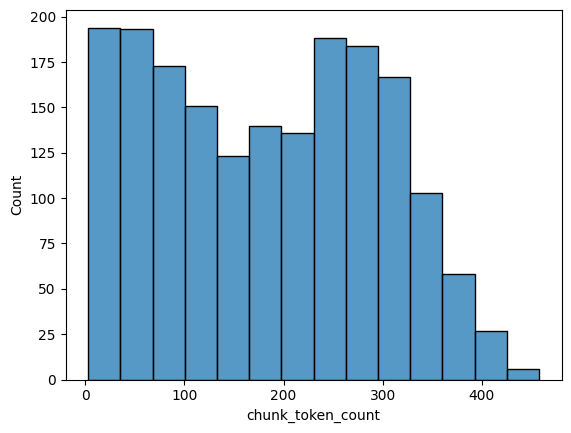

In [21]:
sns.histplot(x='chunk_token_count', data=df)

The embedding model that we are going to use has 384 token limit and from the distribution above we can see most of our chunks are having token size less than that

Also there might be sentences that are having very very less tokens which may not carry useful information for our purpose. Let's say chunks with less than 30 tokens can be considered insignificant and be removed

In [22]:
df[df['chunk_token_count']<30].sample(5)

,page_number,sentence_chunk,chunk_char_count,chunk word count,chunk_token_count
1828,1158,Figure 15.1 reused “Silohuette of Three People...,110,16,27.50
1610,1030,U. S. Food and Drug Administration. https:/ /w...,100,14,25.00
308,185,Table 3.5 Salt Substitutes Sodium | 185,39,7,9.75
1343,862,http:/ /www.aafp.org/afp/ 2002/1001/p1217.html...,67,7,16.75
984,629,You can view it online here: Calcium | 629,42,9,10.50


In [23]:
pages_and_chunks = df[df['chunk_token_count']>30].to_dict(orient='records')
len(pages_and_chunks)

1680

In [24]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 88,
  'sentence_chunk': 'the iron-containing hemoglobin molecule in red blood cells serves as the oxygen carrier. Wastes Out In the metabolism of macronutrients to energy, cells produce the waste products carbon dioxide and water. As blood travels through smaller and smaller vessels, the rate of blood flow is dramatically reduced, allowing for efficient exchange of nutrients and oxygen for cellular waste products through tiny capillaries. The kidneys remove any excess water from the blood, and blood delivers the carbon dioxide to the lungs where it is exhaled. Also, the liver produces the waste product urea from the breakdown of amino acids and detoxifies many harmful substances, all of which require transport in the blood to the kidneys for excretion. All for One, One for All The eleven organ systems in the body completely depend on each other for continued survival as a complex organism. Blood allows for transport of nutrients, wastes, water, and heat, and is also a 

## Embedding our text chunks

what is embedding ?


In [27]:
!pip install -U sentence-transformers

In [33]:
import torch
from sentence_transformers import SentenceTransformer

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [32]:
embedding_model = SentenceTransformer(model_name_or_path= 'all-mpnet-base-v2', device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentences are encoded/embedded to a numerical representation using `model.encode()`

In [35]:
sentences = ['Embeddings are representations of values or objects like text, images, and audio that are designed to be consumed by machine learning models and semantic search algorithms.',
'They translate objects like these into a mathematical form according to the factors or traits each one may or may not have, and the categories they belong to']

embeddings = embedding_model.encode(sentences)

for sentence, embedding in zip(sentences, embeddings):
    print(f"Sentence: {sentence}")
    print(f"Shape of the embedding:{(embedding.shape)}")
    break

Sentence: Embeddings are representations of values or objects like text, images, and audio that are designed to be consumed by machine learning models and semantic search algorithms.
Shape of the embedding:(768,)


More the embedding size better the results are in capturing the sentence meaning in a vector form. But also it consumes more space and takes more time in computation.

After embedding the sentences, we can perform a vector search for retrievel of relevant text from the document.


## Embedding all the text chunks of the document

In [39]:
%%time

for item in tqdm(pages_and_chunks):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 30.9 s, sys: 165 ms, total: 31.1 s
Wall time: 34.7 s


Embedding the chunks using batch mode

In [40]:
## extract all text chunks into a list

text_chunks = [item['sentence_chunk'] for item in pages_and_chunks]
len(text_chunks)

1680

In [42]:
text_chunk_embeddings = embedding_model.encode(
    text_chunks,
    batch_size=32,
    convert_to_tensor=True
)
text_chunk_embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

Embedding in batch mode is generally faster and preferred way.


## Saving embeddings to a file